# Trial Practical: CCA for Seasonal Data
Downloading Some Data and Using XCast to Make a Seasonal Forecast Using Some Forecast Models and CCA Postprocessing Technique Over Pac Islands



## Libraries

In [100]:
import xcast as xc
import cptdl as dl 
import cptio as cio
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

In [101]:
#Directory Setup, pick your project folder
project_dir = '/Users/katie/Desktop/trial_pacisl' #setup directory where you want to work for this project

os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
os.makedirs(os.path.join(project_dir, 'figures'), exist_ok = True)
os.makedirs(os.path.join(data_dir, 'tsv_files'), exist_ok = True)
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)

data_dir = os.path.join(project_dir, 'practical_data')
tsv_dir = os.path.join(data_dir, 'tsv_files')
nc_dir = os.path.join(data_dir, 'nc_files')
figure_dir = os.path.join(project_dir, 'figures')

## Download Some Trial Data

In [102]:
MOS = 'CCA' # must be one of 'CCA', 'PCR'

# Use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors.
# Make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands.
gcms = [ 'GEOSS2S.PRCP','SPEAR.PRCP', 'CCSM4.PRCP', 'CanSIPSIC3.PRCP', 'CFSv2.PRCP']
#predictand_name = 'UCSB0p05.PRCP'
predictand_name = 'UCSB.PRCP'

download_args = { 
    # 'fdate':
    #   The initialization date of the model forecasts / hindcasts.
    #   This field is defined by a python datetime.datetime object,
    #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
    #   The year field is only used for forecasts, otherwise ignored.
    #   The day field is only used in subseasonal forecasts, otherwise ignored.
    #   The month field is an integer representing a month - ie, May=5.
    'fdate':  dt.datetime(2024, 5, 1),

    # 'first_year':
    #   The first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
    #   Double check that your model has hindcast data for all years in [first_year, final_year].
    #   This field is defined by a python integer representing a year, e.g. 1993.
    'first_year': 1993,  

    # 'final_year':
    #   The final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
    #   Double check that your model has hindcast data for all years in [first_year, final_year].
    #   This field is defined by a python integer representing a year, e.g. 2016.
    'final_year': 2016,  

    # 'target': 
    #   Mmm-Mmm indicating the months included in the target period of the forecast. 
    #   This field is defined by a python string, with two three-letter month name abbreviations 
    #   whose first letters are capitalized, and all other letters are lowercase
    #   and who are separated by a dash character. 
    #   For example, if you wanted a JJA target period, you would use 'Jun-Aug'.
    'target': ['Jun-Aug','Jul-Sep','Aug-Oct'],
    'lead_low':[1.5,2.5,3.5],#1.5 month lead is the following month (e.g. for initialization in May, a forecast in June)
    'lead_high':[3.5,4.5,5.5],

    # 'predictor_extent':
    #   The geographic bounding box of the climate model data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictor_extent': {
        'east':  120,
        'west': 250, 
        'north': 10,
        'south': -30, 
      }, 

    # 'predictand_extent':
    #   The geographic bounding box of the observation data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictand_extent': {
        'east':  155,
        'west': 181,  
        'north': 3,  
        'south': -20, 
      },

    # 'filetype':
    #   The filetype to be downloaded. for now, it saves a lot of headache just to set this equal
    #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata.
    'filetype': 'cptv10.tsv'    
}


In [103]:
# Download Observations
obs_leads = []
for l, lead in enumerate(download_args['lead_low']):
    obs_download_file = '_'.join([download_args['target'][l], str(lead), predictand_name])
    print(obs_download_file)
    l_download = download_args.copy()
    l_download['lead_low'] = lead
    l_download['lead_high'] = download_args['lead_high'][l]
    l_download['target'] = download_args['target'][l]

    print(os.path.join(nc_dir,'{}.nc'.format(obs_download_file)))
    if not Path(os.path.join(nc_dir,'{}.nc'.format(obs_download_file))).is_file():
        print('STARTING DOWNLOAD OF {}'.format(obs_download_file))
        if not Path(os.path.join(tsv_dir, '{}.tsv'.format(obs_download_file))).is_file():
            Y = dl.download(dl.observations[predictand_name], os.path.join(tsv_dir,'{}.tsv'.format(obs_download_file)), **l_download, verbose=True, use_dlauth=False)
        else:
            Y = g = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(obs_download_file)))
        Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[predictand_name]})
        Y.to_netcdf(os.path.join(nc_dir,'{}.nc'.format(obs_download_file)))
        print()
    else:
        Y = xr.open_dataset(os.path.join(nc_dir, '{}.nc'.format(obs_download_file)))
        Y = getattr(Y, [i for i in Y.data_vars][0])
    Y = Y.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
    obs_leads.append(Y)
obs_leads = xr.concat(obs_leads, dim = 'L')

Jun-Aug_1.5_UCSB.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Jun-Aug_1.5_UCSB.PRCP.nc
STARTING DOWNLOAD OF Jun-Aug_1.5_UCSB.PRCP

Jul-Sep_2.5_UCSB.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Jul-Sep_2.5_UCSB.PRCP.nc
STARTING DOWNLOAD OF Jul-Sep_2.5_UCSB.PRCP

Aug-Oct_3.5_UCSB.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Aug-Oct_3.5_UCSB.PRCP.nc
STARTING DOWNLOAD OF Aug-Oct_3.5_UCSB.PRCP



In [108]:
# Download GCMs and save raw models to netcdf
hindcast_data, forecast_data = [], []
for l, lead in enumerate(download_args['lead_low']):
    l_download = download_args.copy()
    l_download['lead_low'] = lead
    l_download['lead_high'] = download_args['lead_high'][l]
    l_download['target'] = download_args['target'][l]
    hindcast_data_l, forecast_data_l = [], []
    for gcm in gcms:
        gcm_hindcast_download_file = '_'.join([l_download['target'], str(lead), '_raw_hind' +gcm])
        gcm_forecast_download_file = '_'.join([l_download['target'], str(lead), '_raw_fcst' + gcm])
        if not Path(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file))).is_file():
            if not Path(os.path.join(tsv_dir,'{}.tsv'.format(gcm_forecast_download_file))).is_file():
                print('STARTING DOWNLOAD OF {}'.format(gcm + str(lead) + l_download['target']))
                g = dl.download(dl.hindcasts[gcm], os.path.join(tsv_dir,'{}.tsv'.format(gcm_hindcast_download_file)), **l_download, verbose=True, use_dlauth=False)
                f = dl.download(dl.forecasts[gcm], os.path.join(tsv_dir,'{}.tsv'.format(gcm_forecast_download_file)), **l_download, verbose=True, use_dlauth=False)
                g = getattr(g, [i for i in g.data_vars][0])
                f = getattr(f, [i for i in f.data_vars][0])
                print()
            else:
                print('LOADING {} FROM FILE'.format(gcm))
                g = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(gcm_hindcast_download_file)))
                f = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(gcm_forecast_download_file)))
                print()
                g = getattr(g, [i for i in g.data_vars][0])
                f = getattr(f, [i for i in f.data_vars][0])
            #label datasets by model name
            g = g.expand_dims({'M':[gcm]})
            f = f.expand_dims({'M':[gcm]})
            
            #regrid models to observation coordinates for consistent grids across models
            #g = xc.regrid(g, Y.coords['X'].values, Y.coords['Y'].values)
            #f = xc.regrid(f, Y.coords['X'].values, Y.coords['Y'].values)
        
            nc_prep = xr.concat(g, 'M')
            nc_prep.to_netcdf(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file)))
            f_nc_prep = xr.concat(f, 'M')
            f_nc_prep.to_netcdf(os.path.join(nc_dir, '{}.nc'.format(gcm_forecast_download_file)))
        else:
            g = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file)))
            f = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file)))
        hindcast_data_l.append(g)
        forecast_data_l.append(f)
    hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
    forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
    hindcast_data_l = hindcast_data_l.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
    forecast_data_l = forecast_data_l.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
    hindcast_data.append(hindcast_data_l)
    forecast_data.append(forecast_data_l)
hindcast_data = xr.concat(hindcast_data, dim = 'L').prec
forecast_data = xr.concat(forecast_data, dim = 'L').prec

In [109]:
hindcast_data

<xarray.DataArray 'prec' (L: 3, M: 5, S: 24, Y: 41, X: 131)> Size: 15MB
array([[[[[1.43522e+03, 1.44824e+03, 1.51683e+03, ..., 1.21272e+03,
           1.09938e+03, 1.14987e+03],
          [1.82056e+03, 1.64900e+03, 1.54286e+03, ..., 1.14305e+03,
           9.75989e+02, 8.73354e+02],
          [1.52086e+03, 1.71323e+03, 1.56820e+03, ..., 9.12307e+02,
           8.26128e+02, 7.74008e+02],
          ...,
          [5.12188e+02, 5.12207e+02, 4.99330e+02, ..., 4.10824e+01,
           5.36239e+01, 6.43003e+01],
          [4.91500e+02, 5.08635e+02, 4.91958e+02, ..., 4.58855e+01,
           5.02431e+01, 5.08933e+01],
          [5.11105e+02, 5.10226e+02, 5.08835e+02, ..., 4.48087e+01,
           4.55049e+01, 5.21670e+01]],

         [[1.51912e+03, 1.49399e+03, 1.53393e+03, ..., 1.03560e+03,
           9.34361e+02, 8.85767e+02],
          [1.58061e+03, 1.60132e+03, 1.65065e+03, ..., 8.99025e+02,
           7.93853e+02, 7.48398e+02],
          [1.58007e+03, 1.57452e+03, 1.61363e+03, ..., 7.42445e+02,
           7.44996e+02, 6.90638e+02],
...
          [5.51070e+02, 5.78486e+02, 6.05529e+02, ..., 5.35833e+01,
           5.10697e+01, 5.00485e+01],
          [5.96257e+02, 6.20771e+02, 6.39258e+02, ..., 5.69036e+01,
           5.40332e+01, 5.42023e+01],
          [6.28113e+02, 6.48456e+02, 6.58430e+02, ..., 5.97136e+01,
           6.12806e+01, 6.95489e+01]],

         [[1.80959e+03, 1.75882e+03, 1.73512e+03, ..., 1.51086e+03,
           1.83909e+03, 1.73327e+03],
          [1.73507e+03, 1.74262e+03, 1.72144e+03, ..., 1.87836e+03,
           1.92207e+03, 1.35494e+03],
          [1.26112e+03, 1.18555e+03, 1.13924e+03, ..., 1.67381e+03,
           1.86394e+03, 1.47093e+03],
          ...,
          [2.91963e+02, 3.08687e+02, 3.22967e+02, ..., 4.77107e+01,
           4.61334e+01, 4.47807e+01],
          [3.29506e+02, 3.43471e+02, 3.51500e+02, ..., 5.24614e+01,
           4.96041e+01, 5.11252e+01],
          [3.57965e+02, 3.73654e+02, 3.78815e+02, ..., 5.76557e+01,
           5.82574e+01, 6.37063e+01]]]]])
Coordinates:
  * L        (L) int64 24B 1 2 3
  * M        (M) <U15 300B 'GEOSS2S.PRCP' 'SPEAR.PRCP' ... 'CFSv2.PRCP'
    T        (L, S) datetime64[ns] 576B 1993-07-16T12:00:00 ... 2016-09-15T12...
    Ti       (L, S) datetime64[ns] 576B 1993-06-01 1994-06-01 ... 2016-08-01
    Tf       (L, S) datetime64[ns] 576B 1993-08-31 1994-08-31 ... 2016-10-31
  * Y        (Y) float64 328B 10.0 9.0 8.0 7.0 6.0 ... -27.0 -28.0 -29.0 -30.0
  * X        (X) float64 1kB 250.0 249.0 248.0 247.0 ... 123.0 122.0 121.0 120.0
  * S        (S) datetime64[ns] 192B 1993-05-01 1994-05-01 ... 2016-05-01
Attributes:
    field:          prec
    L:              2.5 months
    nrow:           41
    ncol:           131
    row:            Y
    col:            X
    units:          mm/day
    standard_name:  lwe_precipitation_rate
    missing:        -999

## Trialling Out Ways to Correct Raw Model Outputs using Canonical Correlation Analysis

In [110]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, pearson_cca = [],[],[],[],[]

for l in np.unique(hindcast_data.L):
    model = hindcast_data.sel(L=l).swap_dims({'S':'T'})
    obs = obs_leads.sel(L=l).swap_dims({'S':'T'})
    fmodel = forecast_data.sel(L=l).swap_dims({'S':'T'})

    #run CCA
    hindcasts_det, hindcasts_prob = [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=1):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(10,
                                      10,
                                     3))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    #to check the forecast ran, quick plot
    #fBN_plot = fprobs.sel(M='BN').plot()
    #plt.show()
    
    #calculate pearson correlation score for hindcasts
    pearson_calc = xc.Pearson(hindcasts_det, obs)
    pearson_cca.append(pearson_calc)
    #pearson_plot = pearson_calc.plot(vmin=-1,vmax=1, levels = 21, cmap='coolwarm')
    #plt.show()
    
    cca_fcsts_prob.append(fprobs.swap_dims({'T':'S'}))
    cca_hcasts_det.append(hindcasts_det.swap_dims({'T':'S'}))
    cca_hcasts_prob.append(hindcasts_prob.swap_dims({'T':'S'}))
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
pearson_cca = xr.concat(pearson_cca, dim = 'L')
cca_time = time.time() - start_time

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24


In [111]:
cca_time

36.62415385246277

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


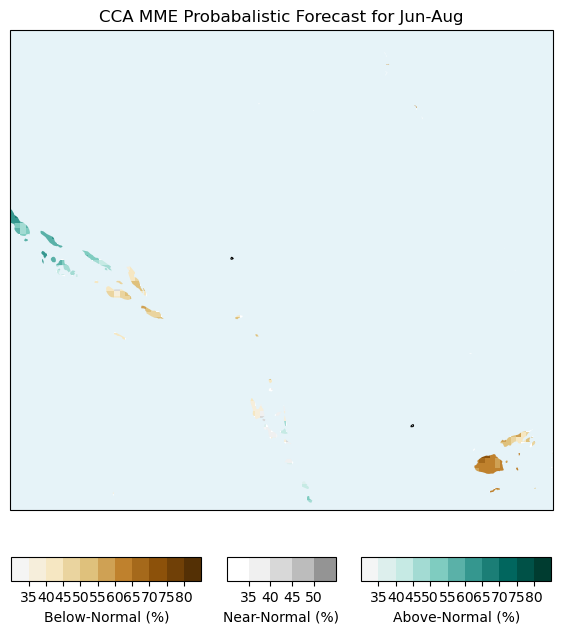

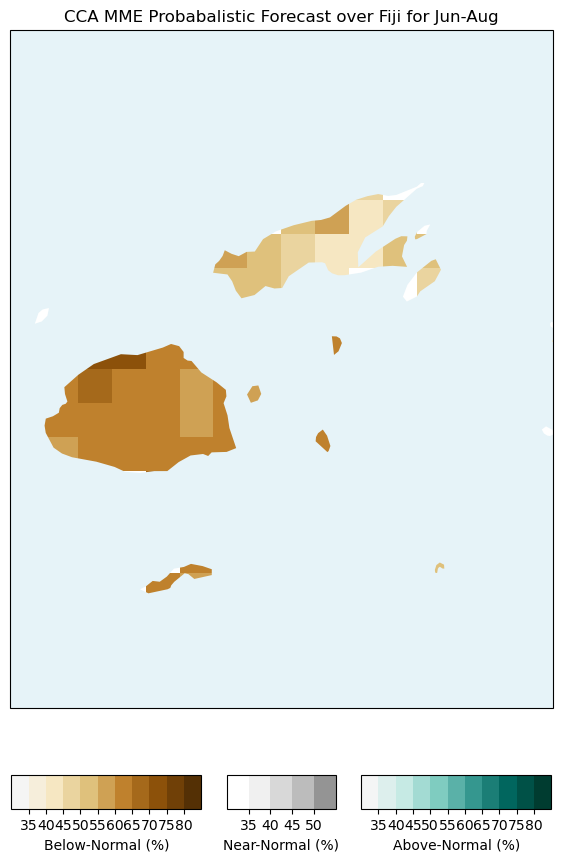

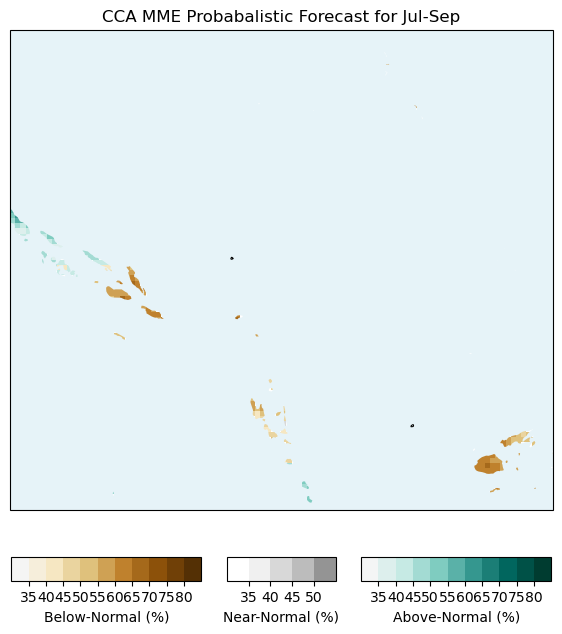

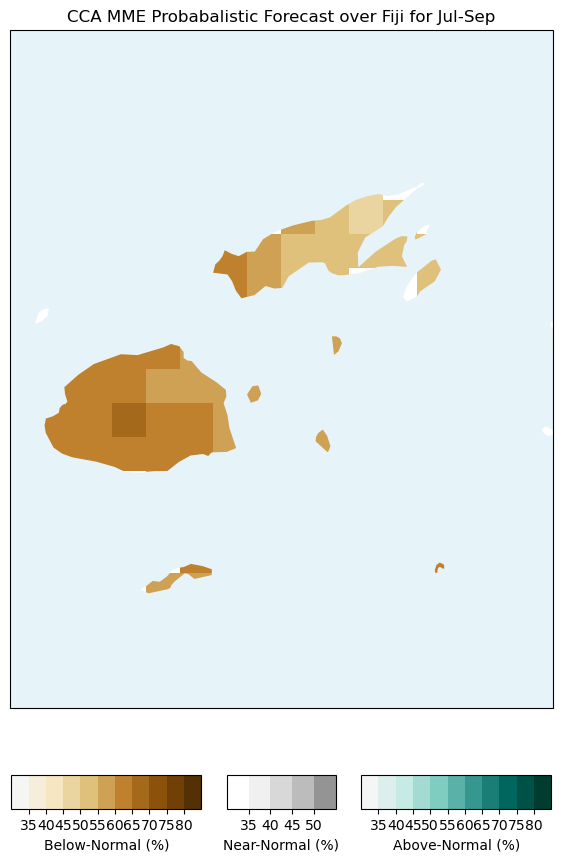

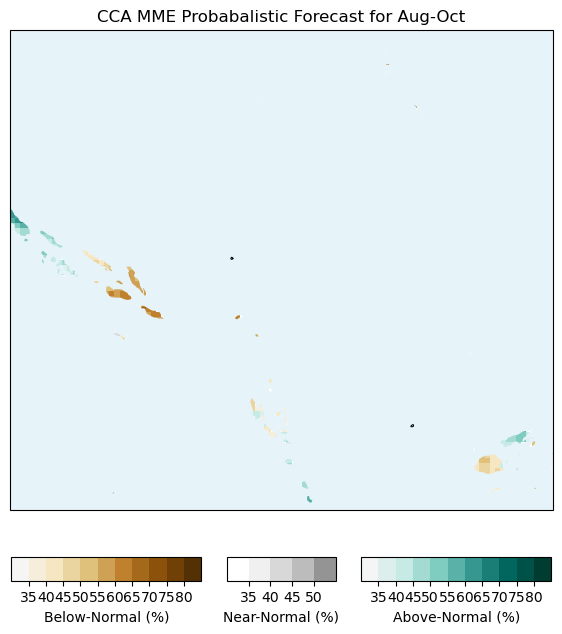

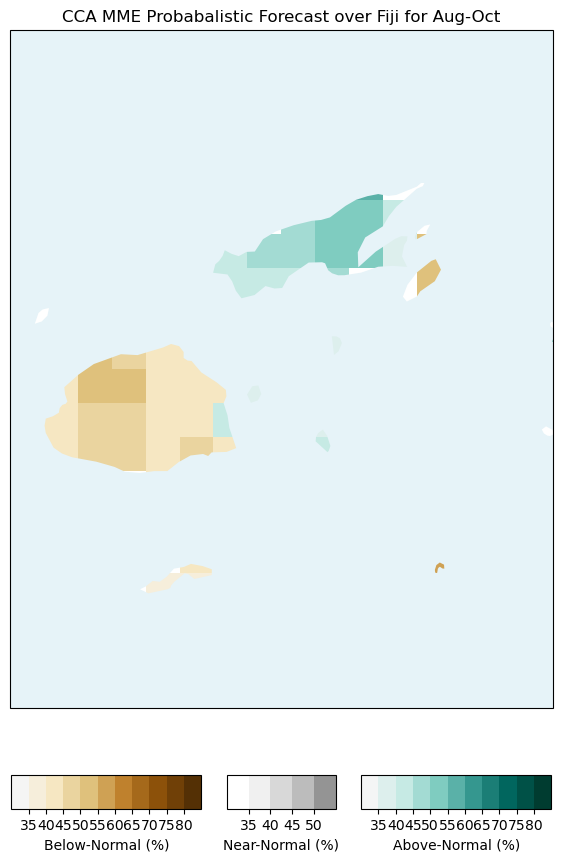

In [112]:
#plot the probabalistic output
from mprob import mview_probabilistic

# Iterate over each month and plot the data
for l, lead in enumerate(np.unique(cca_fcsts_prob.L)):
    im = mview_probabilistic(cca_fcsts_prob.isel(S=0, L=l), 
                             title='CCA MME Probabalistic Forecast for ' + download_args['target'][l],
                             savefig=os.path.join(figure_dir, download_args['target'][l] + 'CCA_forecast25deg.png'))

    im_fiji = mview_probabilistic(cca_fcsts_prob.isel(S=0, L=l).sel(X=slice(182, 177),
                                                                   Y=slice(-15, -20)),
                             title='CCA MME Probabalistic Forecast over Fiji for ' + download_args['target'][l],
                             savefig=os.path.join(figure_dir, download_args['target'][l] + 'Fiji_CCA_forecast25deg.png'))

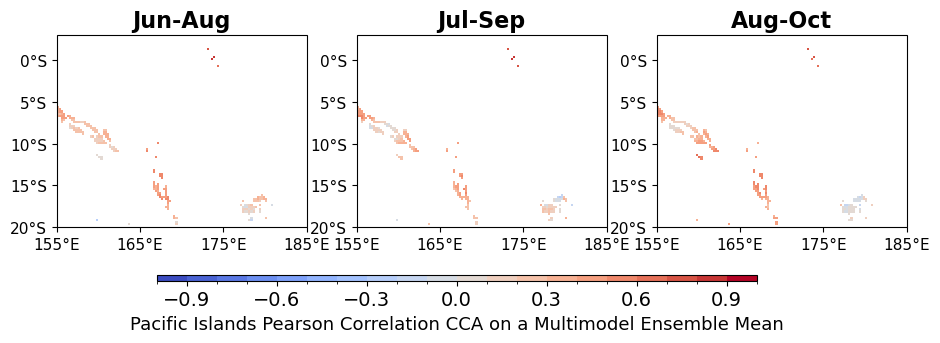

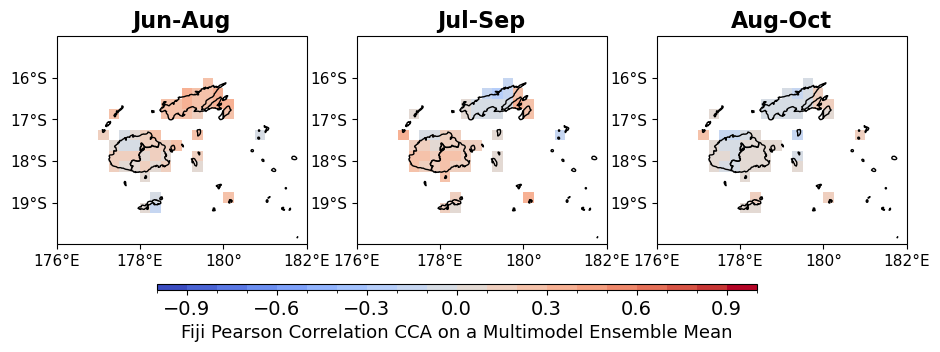

In [113]:
# Create a figure
fig = plt.figure(figsize=(10, 3))

# Iterate over each month and plot the data
for l, lead in enumerate(range(1, 4)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(1, 3, l+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =pearson_cca.isel(L=l).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=-1,vmax=1, levels = 21, cmap='coolwarm',add_colorbar=False)
    # Set title with season name
    ax.set_title(download_args['target'][l], fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    xticks = [155, 165,  175,  185]
    yticks = [-20,  -15,  -10, -5, 0]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set the tick labels
    ax.set_xticklabels(['155°E', '165°E', '175°E', '185°E'])
    ax.set_yticklabels(['20°S', '15°S', '10°S', '5°S', '0°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Pacific Islands Pearson Correlation CCA on a Multimodel Ensemble Mean', fontsize=13)
cbar.ax.tick_params(labelsize=14)

# Show plot
plt.show()

fig = plt.figure(figsize=(10, 3))

# Iterate over each month and plot the data
for l, lead in enumerate(range(1, 4)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(1, 3, l+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =pearson_cca.isel(L=l).sel(X=slice(182, 177), Y=slice(-15, -20)).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=-1,vmax=1, levels = 21, cmap='coolwarm',add_colorbar=False)
    # Set title with season name
    ax.set_title(download_args['target'][l], fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    xticks = [176, 178, 180, 182]
    yticks = [-19,  -18,  -17, -16]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set the tick labels
    ax.set_xticklabels(['176°E', '178°E', '180°', '182°E'])
    ax.set_yticklabels(['19°S', '18°S', '17°S', '16°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fiji Pearson Correlation CCA on a Multimodel Ensemble Mean', fontsize=13)
cbar.ax.tick_params(labelsize=14)

# Show plot
plt.show()

#### Next Steps
1. Add environment install command to beginning of notebook
2. Test our environment is stable - install the environment on windows; and run this notebook
3. Test our environment is stable round two - instlal the environment on linux; and run this notebook
4. Give our document to others to test - Grace and Ehsan to run
5. Download data for other seasons (4 season skill) and upload to google drive
6. Run ELM, EOPLM, and CCA on 25km and 5km and time how long it takes
7. Add GROC skill score
8. Add RMSE skill score
9. Plot Raw Correlation score
10. Plot Bias Correlation score
11. Add Endalk's consolidated weighted ensemble mean based on correlation score
12. Develop an assignment - divide into 4 teams; dividing by seasons - each calculate the raw score, bias corrected, plot the probabalistic forecast

Current run time for CCA
- 77 seconds for 25'; 35 seconds for 5km

In [ ]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs.rename({'lat':'Y', 'lon':'X', 'time':'T'}))
#T = ohc.transform(obs)
# clim = xr.ones_like(T) * 0.333
# print(T)
# groc=xc.GROCS(hindcasts_prob1, T)
# pl=xc.view(groc,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =hindcasts_det1.isel(M=0, time=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =obs.isel(year=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
hindcasts_det.isel(M=0,time=3).plot()

In [ ]:
splot = chirps_pacisl.precip.plot(col = 'time', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})
                                  # (transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
#splot = splot.plot(transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
for ax in  splot.axs.flat:
    coasts = ax.coastlines()
    ax.set_xlim(pred_w, pred_e)
    ax.set_ylim(pred_s, pred_n)
plt.show()

In [ ]:
hmodelt = nmme_mme_hcst.precip.expand_dims({'M':[0]})
fmodelt = nmme_mme_fcst.precip.expand_dims({'M':[0]})
obs = chirps_hcst.precip.expand_dims({'M':[0]})

drymask = xc.drymask(obs, dry_threshold= cfg.dry_threshold)#, quantile_threshold=cfg.quantile_threshold)
obs = obs*drymask
drymask = xc.drymask(hmodelt, cfg.dry_threshold, cfg.quantile_threshold)
modelt = hmodelt*drymask